In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from numpy.random import RandomState, default_rng

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, precision_recall_curve, PrecisionRecallDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier

from hyperopt import hp, fmin, STATUS_OK, tpe

## CONSTANTS ##

# For XGBoost, the output code size is only affected by the first two constants
NUM_ESTIMATORS = 20 # Number of trees
MAX_DEPTH = 7 # (Roughly) size of each tree
MAX_EVAL = 100
RAND_SEED = 42

We first load in the large, medium, and small datasets then filter by the respective column sets

In [2]:
def filter_columns(columns, df):
    column_names = columns["Feature"].tolist()
    return df[column_names + ["benign"]]

cols = {
    "df10": pd.read_csv("/kaggle/input/feature-importance-study-on-the-ciciot2023-export/topall.csv"),
    "df1": pd.read_csv("/kaggle/input/feature-importance-study-on-the-ciciot2023-export/top24.csv"),
    "df01": pd.read_csv("/kaggle/input/feature-importance-study-on-the-ciciot2023-export/top5.csv")
}

dfs = {
  "df10": filter_columns(cols["df10"], pd.read_csv("/kaggle/input/k/yenzeinkok/creating-a-smaller-dataset-for-ciciot2023/0.1percent_2classes.csv")),
  "df1": filter_columns(cols["df1"], pd.read_csv("/kaggle/input/k/yenzeinkok/creating-a-smaller-dataset-for-ciciot2023/0.05percent_2classes.csv")),
  "df01": filter_columns(cols["df01"], pd.read_csv("/kaggle/input/k/yenzeinkok/creating-a-smaller-dataset-for-ciciot2023/0.01percent_2classes.csv")),
}

val_dfs = {
  "df10": filter_columns(cols["df10"], pd.read_csv("/kaggle/input/k/yenzeinkok/creating-a-smaller-dataset-for-ciciot2023/0.01percent_validation_2classes.csv")),
  "df1": filter_columns(cols["df1"], pd.read_csv("/kaggle/input/k/yenzeinkok/creating-a-smaller-dataset-for-ciciot2023/0.01percent_validation_2classes.csv")),
  "df01": filter_columns(cols["df01"], pd.read_csv("/kaggle/input/k/yenzeinkok/creating-a-smaller-dataset-for-ciciot2023/0.01percent_validation_2classes.csv")),
}

print(len(dfs["df10"].index))
print(len(dfs["df1"].index))
print(len(dfs["df01"].index))

4668665
2334325
466869


# Processing Dataset

Normalize the dataset and split it into Train - Test - Validation splits.
The chosen proportion is: 70 - 20 - 10 respectively.

In [3]:
# Convert to reduced space dtypes to save data
dtypes = {
        'flow_duration': np.float32,
        'header_length': np.uint32,
        'duration': np.float32,
        'rate': np.uint32,
        'srate': np.uint32,
        'drate': np.float32,
        'fin_flag_number': np.float32,
        'syn_flag_number': np.float32,
        'rst_flag_number': np.float32,
        'psh_flag_number': np.float32,
        'ack_flag_number': np.float32,
        'ece_flag_number': np.float32,
        'cwr_flag_number': np.float32,
        'ack_count': np.float32,
        'syn_count': np.float32,
        'fin_count': np.float32,
        'urg_count': np.float32, 
        'rst_count': np.float32,
        'tot_sum': np.float32, 
        'min': np.float32, 
        'max': np.float32, 
        'avg': np.float32, 
        'std': np.float32, 
        'tot_size': np.float32, 
        'iat': np.float32, 
        'number': np.float32,
        'magnitude': np.float32, 
        'radius': np.float32, 
        'covariance': np.float32, 
        'variance': np.float32, 
        'weight': np.float32, 
        'benign': np.float32,
    }

def preprocess(df):
    if ("protocol_type" in df.columns):
        df = df.drop("protocol_type", axis=1)
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    # Adjust data type
    for col in scaled_df.columns:
        scaled_df[col] = scaled_df[col].astype(np.float32)
    
    return (scaled_df, scaler)

def preprocess_with_scaler(df, scaler):
    if ("protocol_type" in df.columns):
        df = df.drop("protocol_type", axis=1)
    scaled_df = pd.DataFrame(scaler.transform(df), columns=df.columns)
    
    # Adjust data type
    for col in scaled_df.columns:
        scaled_df[col] = scaled_df[col].astype(np.float32)
    
    return scaled_df

In [4]:
def preprocess_dataset(df, df_val):
    # Preprocess variables then split
    y = pd.Series(df["benign"])
    X = df.drop("benign", axis=1)

    X, scaler = preprocess(X)
    
    y_val = pd.Series(df_val["benign"])
    X_val = df_val.drop(["benign"], axis=1)
    X_val = preprocess_with_scaler(X_val, scaler)
    

    # Train - Test - Val: 70% - 20% - 10%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RAND_SEED)
    
    return (X_train, X_test, X_val, y_train, y_test, y_val, scaler)

# Training Models

We use TPE to determine the best hyperparmeters, utilizing the hyperopt library. To do so, we need to define the objective function, which returns the loss of a model trained on a specific 

In [5]:
## Inspired by: https://www.kaggle.com/code/yassinealouini/hyperopt-the-xgboost-model/script

# We choose PR AUC due to the imbalanced dataset (~2% of dataset is benign)

# Determine the best set of hyperparameters using TPE
def optimize_xgb(X_train, y_train, X_val, y_val):
    
    # Objective function for evaluating a model trained off a given set of parameters
    def objective(params):
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        eval_set = [(dval, "eval"), (dtrain, "train")]

        # Get model performance
        model = xgb.train(params, dtrain, NUM_ESTIMATORS, evals=eval_set, verbose_eval=False)
        y_pred = model.predict(dval)

        precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
        score = auc(recall, precision)

        loss = 1 - score
        return { "loss": loss, "status": STATUS_OK }
    
    space = {
        "eta": hp.quniform("eta", 0.01, 0.5, 0.01),
        "gamma": hp.quniform("gamma", 0, 1, 0.05),
        "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
        "subsample": hp.quniform("subsample", 0.5, 1, 0.1),
        "max_depth": MAX_DEPTH,
        "colsample_bytree": hp.quniform("colsample_bytree", 0.5, 1, 0.1),
        "eval_metric": "aucpr",
        "objective": "binary:logistic",
        "booster": "gbtree",
        "n_jobs": 4,
        "seed": RAND_SEED
    }
    
    best_hparam = fmin(objective, space, algo=tpe.suggest, max_evals=MAX_EVAL, rstate=default_rng(RAND_SEED))
    print(f"Best hyperparams:\n{best_hparam}")
    
    return best_hparam


# Train and score a model on a specific set of params
def train_model_xgb(params, X_train, y_train, X_val, y_val):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    eval_set = [(dval, "eval"), (dtrain, "train")]

    model = xgb.XGBClassifier(**params, n_estimators=NUM_ESTIMATORS, random_state=RAND_SEED)
    model = model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    
    return model

    
def evaluate_model_xgb(model, X_test, y_test):
    dtest = xgb.DMatrix(X_test, label=y_test)
    # Would use this, but output_margin=True gives the raw prediction values, not probabilities (i.e. after logistic fn processing)
    # y_pred = model.predict(X_test, output_margin=True)
    
    # See: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier.predict_proba
    # Gives us a list of 2-long arrs: arr[0] is prob that class is negative, and arr[1] is prob that class is positive
    y_prob = model.predict_proba(X_test)[:, 1]
    
    precision, recall, threshold = precision_recall_curve(y_test, y_prob)
    
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    return (precision, recall)

Now for each dataset, we train an XGBoost classifer and evaluate its performance. Training involves the following steps:
- Preprocessing data
- Split into train/test/validation sets
- Optimize hyperparmeters on the train/validation sets
- Evaluate on the test set

Training model on dataframe df10
100%|██████████| 100/100 [28:50<00:00, 17.30s/trial, best loss: 0.020880564920510603]
Best hyperparams:
{'colsample_bytree': 1.0, 'eta': 0.47000000000000003, 'gamma': 0.8500000000000001, 'min_child_weight': 2.0, 'subsample': 0.8}
[0]	validation_0-logloss:0.09396
[1]	validation_0-logloss:0.06102
[2]	validation_0-logloss:0.04137
[3]	validation_0-logloss:0.02941
[4]	validation_0-logloss:0.02183
[5]	validation_0-logloss:0.01721
[6]	validation_0-logloss:0.01413
[7]	validation_0-logloss:0.01228
[8]	validation_0-logloss:0.01099
[9]	validation_0-logloss:0.01024
[10]	validation_0-logloss:0.00972
[11]	validation_0-logloss:0.00937
[12]	validation_0-logloss:0.00919
[13]	validation_0-logloss:0.00895
[14]	validation_0-logloss:0.00882
[15]	validation_0-logloss:0.00871
[16]	validation_0-logloss:0.00867
[17]	validation_0-logloss:0.00864
[18]	validation_0-logloss:0.00857
[19]	validation_0-logloss:0.00845
Scoring model from dataframe df10
              precision    recall

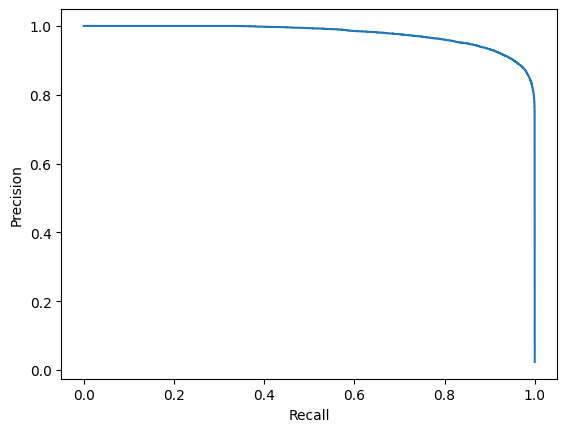

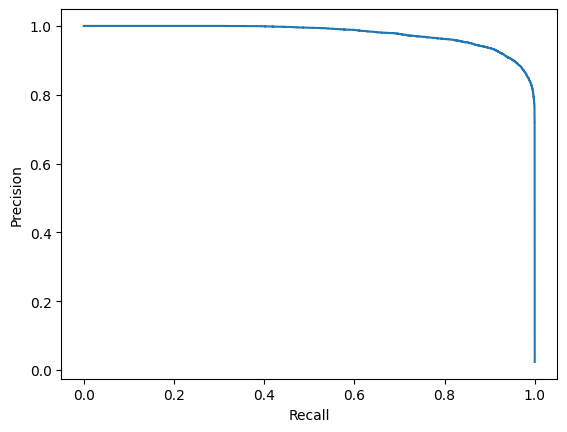

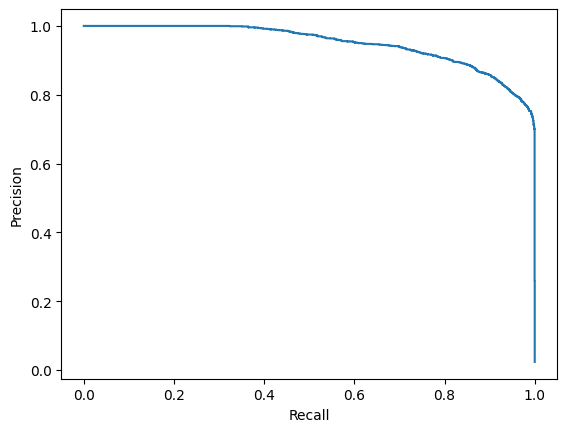

In [6]:
def test_and_train(name, df, optfn):
    X_train, X_test, X_val, y_train, y_test, y_val, scaler = preprocess_dataset(df, val_dfs[name])
    
    def train(name, df):
        print(f"Training model on dataframe {name}")

        best_hparams = optfn(X_train, y_train, X_val, y_val)
        model = train_model_xgb(best_hparams, X_train, y_train, X_val, y_val)

        return model

    def test(name, model):
        print(f"Scoring model from dataframe {name}")
        precision, recall = evaluate_model_xgb(model, X_test, y_test)

        # Plot model
        pr_plot = PrecisionRecallDisplay(precision, recall)
        pr_plot.plot()

        prauc = auc(recall, precision)
        print(f"PR-AUC: {prauc}")
        return prauc
    
    model = train(name, df)
    return (model, test(name, model), scaler)

trained_models_xgb = {}
scalers_xgb = {}
for name, df in dfs.items():
    model, score, scaler = test_and_train(name, df, optimize_xgb)
    
    trained_models_xgb[name] = model
    scalers_xgb[name] = scaler

## Export

First we generate the models using m2cgen

In [7]:
!pip install m2cgen

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 1.7 MB/s eta 0:00:00


In [8]:
import m2cgen as m2c

for name, model in trained_models_xgb.items():
    # Workaround for m2cgen -- see: https://github.com/BayesWitnesses/m2cgen/issues/581#issuecomment-1613836749
    if (model.base_score == None):
        model.base_score = 0
    code = m2c.export_to_c(model)
    with open(f"/kaggle/working/xgb_m2c_{name}.c", "w") as file:
        file.write(code)

    code = m2c.export_to_python(model)
    with open(f"/kaggle/working/xgb_m2c_{name}.py", "w") as file:
        file.write(code)
# base_model.base_score = None
# code = port(base_model)

Then we export the standard scalers as functions that take in a row of features and returns a scaled row of features. Note that they have 2 values that matter per column: mean and standard deviation. This is designed to work with the StandardScaler object, with default settings.

The values are exported deliniated by newlines, and ordered according to the dataframe's column order

In [9]:
def export_scaler(name, means, stds):
    np.savetxt(f"/kaggle/working/scaler_{name}_means.csv", means)
    np.savetxt(f"/kaggle/working/scaler_{name}_stds.csv", stds)

### Quick test
# testfn = export_scaler_python(scalers["df10"].mean_, scalers["df10"].scale_)
# print(testfn(list(dfs["df10"].iloc[0].drop("benign"))))
# print(scalers["df10"].transform(dfs["df10"].iloc[0:1].drop("benign", axis=1)))

for name, scaler in scalers_xgb.items():
    export_scaler(name, scaler.mean_, scaler.scale_)

# Random Forest

In [10]:
# Determine the best set of hyperparameters using TPE
def optimize_rf(X_train, y_train, X_val, y_val):
    
    def cast_params(params):
        int_params = ["min_samples_split", "min_samples_leaf", "max_leaf_nodes"]
        for name, p in params.items():
            if name in int_params:
                params[name] = int(params[name])
                
        return params
    
    # Objective function for evaluating a model trained off a given set of parameters
    def objective(params):
        # Get model performance
        params = cast_params(params)
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]

        precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
        score = auc(recall, precision)

        loss = 1 - score
        return { "loss": loss, "status": STATUS_OK }
    
    class_weights = ["balanced", "balanced_subsample", None]
    space = {
        "min_samples_split": hp.quniform("min_samples_split", 2, 20, 1),
        "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 50, 1),
        "max_features": hp.quniform("max_features", 0.3, 1.0, 0.05),
        "max_leaf_nodes": hp.quniform("max_leaf_nodes", 2, 50, 2),
        "min_impurity_decrease": hp.quniform("min_impurity_decrease", 0.0, 0.5, 0.05),
        "class_weight": hp.choice("class_weight", ["balanced", "balanced_subsample", None]),
        "ccp_alpha": hp.quniform("ccp_alpha", 0.0, 1.0, 0.05),
        "n_estimators": NUM_ESTIMATORS,
        "max_depth": MAX_DEPTH,
        "random_state": RAND_SEED,
        "n_jobs": 4,
    }
    
    best_hparam = fmin(objective, space, algo=tpe.suggest, max_evals=MAX_EVAL, rstate=default_rng(RAND_SEED))
    # hp.choice returns the INDEX of best of the list of choices passed to it
    best_hparam["class_weight"] = class_weights[best_hparam["class_weight"]]
    best_hparam = cast_params(best_hparam)
    print(f"Best hyperparams:\n{best_hparam}")
    
    return best_hparam


# Train and score a model on a specific set of params
def train_model_rf(params, X_train, y_train):
    model = RandomForestClassifier(**params)
    model = model.fit(X_train, y_train)
    
    return model

    
def evaluate_model_rf(model, X_test, y_test):
    # Would use this, but output_margin=True gives the raw prediction values, not probabilities (i.e. after logistic fn processing)
    # y_pred = model.predict(X_test, output_margin=True)
    
    # See: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier.predict_proba
    # Gives us a list of 2-long arrs: arr[0] is prob that class is negative, and arr[1] is prob that class is positive
    y_prob = model.predict_proba(X_test)[:, 1]
    
    precision, recall, threshold = precision_recall_curve(y_test, y_prob)
    
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    return (precision, recall)

Training model on dataframe df10
100%|██████████| 100/100 [1:16:47<00:00, 46.08s/trial, best loss: 0.22558560764115598]
Best hyperparams:
{'ccp_alpha': 0.05, 'class_weight': 'balanced_subsample', 'max_features': 0.45, 'max_leaf_nodes': 28, 'min_impurity_decrease': 0.35000000000000003, 'min_samples_leaf': 22, 'min_samples_split': 19}
Scoring model from dataframe df10
              precision    recall  f1-score   support

       False     0.9996    0.9775    0.9884   1367654
        True     0.5129    0.9852    0.6746     32946

    accuracy                         0.9776   1400600
   macro avg     0.7563    0.9813    0.8315   1400600
weighted avg     0.9882    0.9776    0.9810   1400600

PR-AUC: 0.7645144930011767
Training model on dataframe df1
100%|██████████| 100/100 [43:14<00:00, 25.94s/trial, best loss: 0.025996813725933987]
Best hyperparams:
{'ccp_alpha': 0.0, 'class_weight': None, 'max_features': 1.0, 'max_leaf_nodes': 32, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 50, 'mi

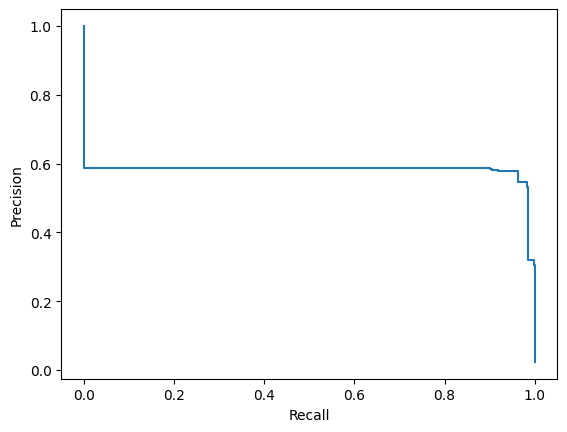

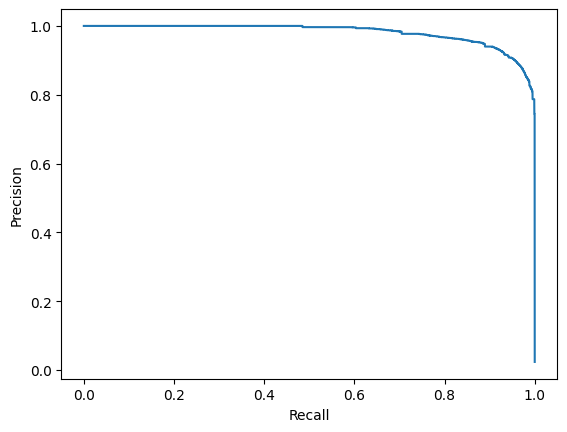

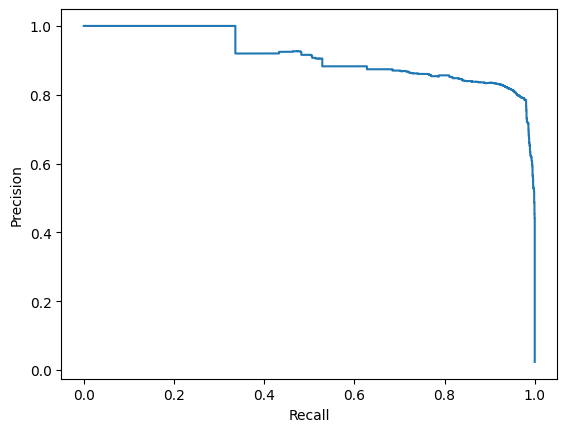

In [11]:
def test_and_train_rf(name, df, optfn):
    X_train, X_test, X_val, y_train, y_test, y_val, scaler = preprocess_dataset(df, val_dfs[name])
    
    def train(name, df):
        print(f"Training model on dataframe {name}")

        best_hparams = optfn(X_train, y_train, X_val, y_val)
        model = train_model_rf(best_hparams, X_train, y_train)

        return model

    def test(name, model):
        print(f"Scoring model from dataframe {name}")
        precision, recall = evaluate_model_rf(model, X_test, y_test)

        # Plot model
        pr_plot = PrecisionRecallDisplay(precision, recall)
        pr_plot.plot()

        prauc = auc(recall, precision)
        print(f"PR-AUC: {prauc}")
        return prauc
    
    model = train(name, df)
    return (model, test(name, model), scaler)

trained_models_rf = {}
scalers_rf = {}
for name, df in dfs.items():
    model, score, scaler = test_and_train_rf(name, df, optimize_rf)
    
    trained_models_rf[name] = model
    scalers_rf[name] = scaler

In [12]:
for name, model in trained_models_rf.items():
    # Workaround for m2cgen -- see: https://github.com/BayesWitnesses/m2cgen/issues/581#issuecomment-1613836749
    code = m2c.export_to_c(model)
    with open(f"/kaggle/working/rf_m2c_{name}.c", "w") as file:
        file.write(code)

    code = m2c.export_to_python(model)
    with open(f"/kaggle/working/rf_m2c_{name}.py", "w") as file:
        file.write(code)